In [36]:
import matplotlib
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.ensemble import VotingClassifier
import warnings #to remove the warnings
import random
import sys
sys.path.append('../../_hepers_')
from genNewVals import generateNewFeatureValMultiple
from genSynData import generateSyntheticDataset
from subsampleData import subsample
from genFillNulls import *
warnings.filterwarnings('ignore')


In [37]:


def trainModels(X_train, X_test, y_train, y_test):
    ''' KNN '''
    
    error = []
    score_vals = []
    for j in range(1, 20):
        knn = KNeighborsRegressor(n_neighbors=j)
        knn.fit(X_train, y_train)
        pred_i = knn.predict(X_test)
        mae = mean_absolute_error(y_test, pred_i)
        error.append(mae)
        score_vals.append(knn.score(X_test, y_test))
        y_pred = knn.predict(X_test)
        y_pred = y_pred == 1
        performanceAccuracy = sum(y_pred == y_test)/len(y_test)
    bestIndex = score_vals.index(max(score_vals)) + 1  #Adds one because it starts with 1 neighbor not 0

    regressor = KNeighborsRegressor(n_neighbors=bestIndex)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    y_pred = y_pred > 0.5
    knnScores = f1_score(y_test, y_pred)

    '''Naive Bayes'''
    nb = GaussianNB()
    nb.fit(X_train, y_train)
    y_pred = (nb.predict(X_test))
    naiveBaysScores = f1_score(y_test, y_pred)

    '''Logistic Regression'''

    modelLogistic = LogisticRegression()
    modelLogistic.fit(X_train,y_train)
    y_pred = modelLogistic.predict(X_test)
    logisticRegressionScores = f1_score(y_test, y_pred)

    '''SVM'''

    svclassifier = SVC(kernel='linear')
    svclassifier.fit(X_train, y_train)
    y_pred = svclassifier.predict(X_test)
    svmRegressionScores = f1_score(y_test, y_pred)
    
    '''Decision Tree'''

    clf = DecisionTreeClassifier()
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    decisionTreeRegressionScores = f1_score(y_test, y_pred)

    '''Voting Classifier'''

    votingCl = VotingClassifier(
            estimators =    [('gnb', GaussianNB()),
                             ('lr',  LogisticRegression()),
                             ('svm', SVC(kernel='linear')),
                             ('dtc', DecisionTreeClassifier(random_state=42))], 
            voting='hard')
    votingCl.fit(X_train, y_train)
    y_pred = votingCl.predict(X_test)
    votingClassifierScore = f1_score(y_test, y_pred)

    return knnScores, naiveBaysScores, logisticRegressionScores, svmRegressionScores, decisionTreeRegressionScores, votingClassifierScore



#('knn', KNeighborsRegressor(n_neighbors=bestIndex)),

In [38]:
raw_df = pd.read_csv('../../../Wisconsin_Database/breast-cancer-wisconsin.data', header=None)
cols = ['ID', 'Thickness', 'SizeUniformity', 'ShapeUniformity', 'Adhesion', 'Size', 'BareNuclei', 'Bland Chromatin', 'Nucleoli', 'Mitoses', 'Diagnosis']
raw_df.columns = cols
raw_df['Diagnosis'] = raw_df['Diagnosis'].map(
                   {2:0,4:1})

temp = []
for index, row in raw_df.iterrows():
    if '?' not in row.values:
        temp.append(row)
        
df = pd.DataFrame(np.array(temp), columns=cols)
df['BareNuclei'] = df['BareNuclei'].astype(np.int)
print(df.shape)
print(df)

for i in df:
    df[i] = df[i].astype(np.int)


(683, 11)
          ID Thickness SizeUniformity ShapeUniformity Adhesion Size  \
0    1000025         5              1               1        1    2   
1    1002945         5              4               4        5    7   
2    1015425         3              1               1        1    2   
3    1016277         6              8               8        1    3   
4    1017023         4              1               1        3    2   
..       ...       ...            ...             ...      ...  ...   
678   776715         3              1               1        1    3   
679   841769         2              1               1        1    2   
680   888820         5             10              10        3    7   
681   897471         4              8               6        4    3   
682   897471         4              8               8        5    4   

     BareNuclei Bland Chromatin Nucleoli Mitoses Diagnosis  
0             1               3        1       1         0  
1            10

In [39]:
augKnnWBC = []
augNbWBC = []
augLrWBC = []
augSvmWBC = []
augDtWBC = []
augVcWBC = []
for i in range(10):
    X = df[cols[1:-1]]
    y = df[cols[-1]]

    SEED = 42 + i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
    finalDataset = generateSyntheticDataset(X_train, y_train, identical = True)
    X_train = finalDataset[finalDataset.columns[:-1]]
    y_train = finalDataset[finalDataset.columns[-1]]
    #print('Augmented X Train: {}'.format(X_train.shape))
    #print('Augmented y_train: {}'.format(y_train.shape))
    scaler = StandardScaler()
    scaler.fit(X_train)

    col_names=df.columns[2:]
    scaled_df = pd.DataFrame(X_train, columns=col_names)
    scaled_df.describe().T
    scores = trainModels(X_train, X_test, y_train, y_test)
    augKnnWBC.append(scores[0])
    augNbWBC.append(scores[1])
    augLrWBC.append(scores[2])
    augSvmWBC.append(scores[3])
    augDtWBC.append(scores[4])
    augVcWBC.append(scores[5])
    print('Iteration: {}'.format(i))


print('KNN - Min: {}, Max: {}, Avg: {}'.format(min(augKnnWBC), max(augKnnWBC), sum(augKnnWBC)/len(augKnnWBC)))
#print('   Best Seed: {}'.format(42 + knnScores.index(max(knnScores))))
print('NB  - Min: {}, Max: {}, Avg: {}'.format(min(augNbWBC), max(augNbWBC), sum(augNbWBC)/len(augNbWBC)))
#print('   Best Seed: {}'.format(42 + naiveBaysScores.index(max(naiveBaysScores))))
print('LR  - Min: {}, Max: {}, Avg: {}'.format(min(augLrWBC), max(augLrWBC), sum(augLrWBC)/len(augLrWBC)))
#print('   Best Seed: {}'.format(42 + logisticRegressionScores.index(max(logisticRegressionScores))))
print('SVM - Min: {}, Max: {}, Avg: {}'.format(min(augSvmWBC), max(augSvmWBC), sum(augSvmWBC)/len(augSvmWBC)))
#print('   Best Seed: {}'.format(42 + svmRegressionScores.index(max(svmRegressionScores))))
print('DT  - Min: {}, Max: {}, Avg: {}'.format(min(augDtWBC), max(augDtWBC), sum(augDtWBC)/len(augDtWBC)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))
print('VC  - Min: {}, Max: {}, Avg: {}'.format(min(augVcWBC), max(augVcWBC), sum(augVcWBC)/len(augVcWBC)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
KNN - Min: 0.9174311926605505, Max: 0.9896907216494846, Avg: 0.96083118555942
NB  - Min: 0.923076923076923, Max: 0.9724770642201834, Avg: 0.951396954915382
LR  - Min: 0.9400000000000001, Max: 0.9724770642201834, Avg: 0.9578669637321056
SVM - Min: 0.9272727272727272, Max: 0.9724770642201834, Avg: 0.952769731842728
DT  - Min: 0.5555555555555556, Max: 0.7073170731707317, Avg: 0.6084656118315352
VC  - Min: 0.9347826086956522, Max: 0.9724770642201834, Avg: 0.9556929737659697


In [40]:
knnWBC = []
nbWBC = []
lrWBC = []
svmWBC = []
dtWBC = []
vcWBC = []
for i in range(10):
    X = df[cols[1:-1]]
    y = df[cols[-1]]

    SEED = 42 + i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
    scaler = StandardScaler()
    scaler.fit(X_train)

    col_names=df.columns[2:]
    scaled_df = pd.DataFrame(X_train, columns=col_names)
    scaled_df.describe().T
    scores = trainModels(X_train, X_test, y_train, y_test)
    knnWBC.append(scores[0])
    nbWBC.append(scores[1])
    lrWBC.append(scores[2])
    svmWBC.append(scores[3])
    dtWBC.append(scores[4])
    vcWBC.append(scores[5])
    print('Iteration: {}'.format(i))



print('KNN - Min: {}, Max: {}, Avg: {}'.format(min(knnWBC), max(knnWBC), sum(knnWBC)/len(knnWBC)))
#print('   Best Seed: {}'.format(42 + knnScores.index(max(knnScores))))
print('NB  - Min: {}, Max: {}, Avg: {}'.format(min(nbWBC), max(nbWBC), sum(nbWBC)/len(nbWBC)))
#print('   Best Seed: {}'.format(42 + naiveBaysScores.index(max(naiveBaysScores))))
print('LR  - Min: {}, Max: {}, Avg: {}'.format(min(lrWBC), max(lrWBC), sum(lrWBC)/len(lrWBC)))
#print('   Best Seed: {}'.format(42 + logisticRegressionScores.index(max(logisticRegressionScores))))
print('SVM - Min: {}, Max: {}, Avg: {}'.format(min(svmWBC), max(svmWBC), sum(svmWBC)/len(svmWBC)))
#print('   Best Seed: {}'.format(42 + svmRegressionScores.index(max(svmRegressionScores))))
print('DT  - Min: {}, Max: {}, Avg: {}'.format(min(dtWBC), max(dtWBC), sum(dtWBC)/len(dtWBC)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))
print('VC  - Min: {}, Max: {}, Avg: {}'.format(min(vcWBC), max(vcWBC), sum(vcWBC)/len(vcWBC)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))



Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
KNN - Min: 0.9174311926605505, Max: 1.0, Avg: 0.9625442562613065
NB  - Min: 0.9215686274509803, Max: 0.9724770642201834, Avg: 0.952020635412493
LR  - Min: 0.9375000000000001, Max: 0.9811320754716981, Avg: 0.9565990029214463
SVM - Min: 0.9347826086956522, Max: 0.9807692307692307, Avg: 0.959822185952666
DT  - Min: 0.8089887640449438, Max: 0.9811320754716981, Avg: 0.92039623700839
VC  - Min: 0.9375000000000001, Max: 0.9811320754716981, Avg: 0.958557008930662


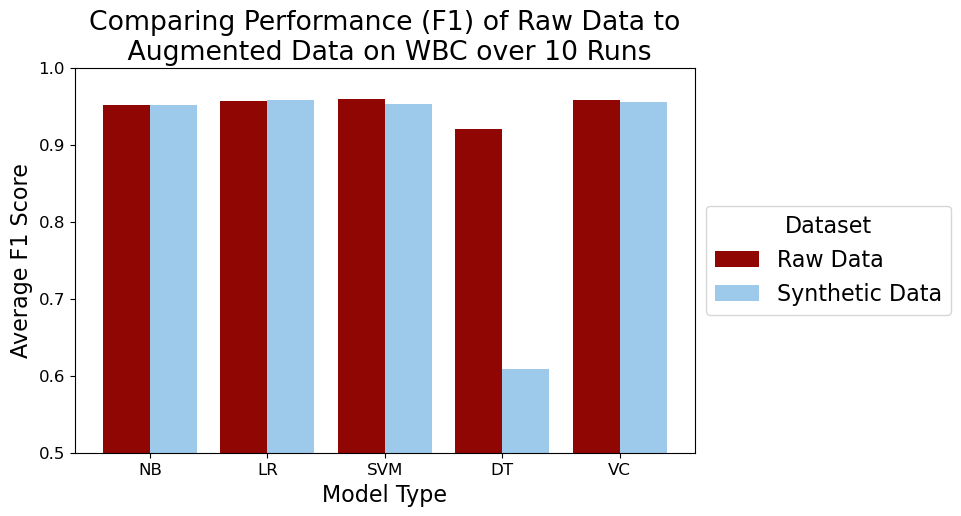

KNN Difference: -0.1713070701886199
NB Difference: -0.062368049711103435
LR Difference: 0.12679608106591633
SVM Difference: -0.7052454109938266
Dt Difference: -31.193062517685455
VC Difference: -0.2864035164692247


In [41]:
import matplotlib.pyplot as plt 
  
X_vals = ['NB','LR','SVM', 'DT', 'VC' ]

wbc_aug = [np.mean(augNbWBC), np.mean(augLrWBC),
        np.mean(augSvmWBC), np.mean(augDtWBC), np.mean(augVcWBC)]
wbc_reg = [np.mean(nbWBC), np.mean(lrWBC),
        np.mean(svmWBC), np.mean(dtWBC), np.mean(vcWBC)]

  
X_axis = np.arange(len(X_vals))
  
plt.bar(X_axis - 0.2, wbc_reg, 0.4, label = 'Raw Data', color='#900603')
plt.bar(X_axis + 0.2, wbc_aug, 0.4, label = 'Synthetic Data', color='#9DCAEB')
  
plt.xticks(X_axis, X_vals)
plt.xlabel("Model Type")
plt.ylabel("Average F1 Score")
plt.ylim(0.5,1)
plt.title("Comparing Performance (F1) of Raw Data to\n Augmented Data on WBC over 10 Runs")
plt.legend(title='Dataset',loc='center left', bbox_to_anchor=(1, 0.5))
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams.update({'font.size': 16})
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.show()


print('KNN Difference: {}'.format(100 * (np.mean(augKnnWBC) - np.mean(knnWBC))))
print('NB Difference: {}'.format(100 * (np.mean(augNbWBC) - np.mean(nbWBC))))
print('LR Difference: {}'.format(100 * (np.mean(augLrWBC) - np.mean(lrWBC))))
print('SVM Difference: {}'.format(100 * (np.mean(augSvmWBC) - np.mean(svmWBC))))
print('Dt Difference: {}'.format(100 * (np.mean(augDtWBC) - np.mean(dtWBC))))
print('VC Difference: {}'.format(100 * (np.mean(augVcWBC) - np.mean(vcWBC))))

In [42]:
cols = ['ID', 'Diagnosis', 'radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension',
        'radius_SE', 'texture_SE', 'perimeter_SE', 'area_SE', 'smoothness_SE', 'compactness_SE', 'concavity_SE', 'concave_points_SE', 'symmetry_SE', 'fractal_dimension_SE',
        'radius_MAX', 'texture_MAX', 'perimeter_MAX', 'area_MAX', 'smoothness_MAX', 'compactness_MAX', 'concavity_MAX', 'concave_points_MAX', 'symmetry_MAX', 'fractal_dimension_MAX']
df = pd.read_csv('../../../Wisconsin_Database/wdbc.data', header=None)

df.columns = cols
df['Diagnosis'] = df['Diagnosis'].map(
                   {'M':True,'B':False})



In [43]:
augKnnWDBC = []
augNbWDBC = []
augLrWDBC = []
augSvmWDBC = []
augDtWDBC = []
augVcWDBC = []
print('Data Shape: {}'.format(df.shape))
for i in range(10):
    X = df[cols[2:]]
    y = df[cols[1]]

    SEED = 42 + i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
    finalDataset = generateSyntheticDataset(X_train, y_train, identical = True)
    X_train = finalDataset[finalDataset.columns[:-1]]
    y_train = finalDataset[finalDataset.columns[-1]]
    scaler = StandardScaler()
    scaler.fit(X_train)

    col_names=df.columns[2:]
    scaled_df = pd.DataFrame(X_train, columns=col_names)
    scaled_df.describe().T
    scores = trainModels(X_train, X_test, y_train, y_test)
    augKnnWDBC.append(scores[0])
    augNbWDBC.append(scores[1])
    augLrWDBC.append(scores[2])
    augSvmWDBC.append(scores[3])
    augDtWDBC.append(scores[4])
    augVcWDBC.append(scores[5])
    print('Iteration: {}'.format(i))


print('KNN - Min: {}, Max: {}, Avg: {}'.format(min(augKnnWDBC), max(augKnnWDBC), sum(augKnnWDBC)/len(augKnnWDBC)))
#print('   Best Seed: {}'.format(42 + knnScores.index(max(knnScores))))
print('NB  - Min: {}, Max: {}, Avg: {}'.format(min(augNbWDBC), max(augNbWDBC), sum(augNbWDBC)/len(augNbWDBC)))
#print('   Best Seed: {}'.format(42 + naiveBaysScores.index(max(naiveBaysScores))))
print('LR  - Min: {}, Max: {}, Avg: {}'.format(min(augLrWDBC), max(augLrWDBC), sum(augLrWDBC)/len(augLrWDBC)))
#print('   Best Seed: {}'.format(42 + logisticRegressionScores.index(max(logisticRegressionScores))))
print('SVM - Min: {}, Max: {}, Avg: {}'.format(min(augSvmWDBC), max(augSvmWDBC), sum(augSvmWDBC)/len(augSvmWDBC)))
#print('   Best Seed: {}'.format(42 + svmRegressionScores.index(max(svmRegressionScores))))
print('DT  - Min: {}, Max: {}, Avg: {}'.format(min(augDtWDBC), max(augDtWDBC), sum(augDtWDBC)/len(augDtWDBC)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))
print('VC  - Min: {}, Max: {}, Avg: {}'.format(min(augVcWDBC), max(augVcWDBC), sum(augVcWDBC)/len(augVcWDBC)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))


Data Shape: (569, 32)
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
KNN - Min: 0.8405797101449276, Max: 0.9249999999999999, Avg: 0.8811620755007367
NB  - Min: 0.8529411764705883, Max: 0.9523809523809524, Avg: 0.9130273346626835
LR  - Min: 0.7297297297297298, Max: 0.8314606741573034, Avg: 0.7726766009565548
SVM - Min: 0.8139534883720929, Max: 0.951219512195122, Avg: 0.8908406969417921
DT  - Min: 0.835820895522388, Max: 0.9610389610389611, Avg: 0.9011586902610235
VC  - Min: 0.8051948051948052, Max: 0.9487179487179487, Avg: 0.8869773722981391


In [44]:
knnWDBC = []
nbWDBC = []
lrWDBC = []
svmWDBC = []
dtWDBC = []
vcWDBC = []
for i in range(10):
    X = df[cols[2:]]
    y = df[cols[1]]

    SEED = 42 + i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
    scaler = StandardScaler()
    scaler.fit(X_train)

    col_names=df.columns[2:]
    scaled_df = pd.DataFrame(X_train, columns=col_names)
    scaled_df.describe().T
    scores = trainModels(X_train, X_test, y_train, y_test)
    knnWDBC.append(scores[0])
    nbWDBC.append(scores[1])
    lrWDBC.append(scores[2])
    svmWDBC.append(scores[3])
    dtWDBC.append(scores[4])
    vcWDBC.append(scores[5])
    print('Iteration: {}'.format(i))



print('KNN - Min: {}, Max: {}, Avg: {}'.format(min(knnWDBC), max(knnWDBC), sum(knnWDBC)/len(knnWDBC)))
#print('   Best Seed: {}'.format(42 + knnScores.index(max(knnScores))))
print('NB  - Min: {}, Max: {}, Avg: {}'.format(min(nbWDBC), max(nbWDBC), sum(nbWDBC)/len(nbWDBC)))
#print('   Best Seed: {}'.format(42 + naiveBaysScores.index(max(naiveBaysScores))))
print('LR  - Min: {}, Max: {}, Avg: {}'.format(min(lrWDBC), max(lrWDBC), sum(lrWDBC)/len(lrWDBC)))
#print('   Best Seed: {}'.format(42 + logisticRegressionScores.index(max(logisticRegressionScores))))
print('SVM - Min: {}, Max: {}, Avg: {}'.format(min(svmWDBC), max(svmWDBC), sum(svmWDBC)/len(svmWDBC)))
#print('   Best Seed: {}'.format(42 + svmRegressionScores.index(max(svmRegressionScores))))
print('DT  - Min: {}, Max: {}, Avg: {}'.format(min(dtWDBC), max(dtWDBC), sum(dtWDBC)/len(dtWDBC)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))
print('VC  - Min: {}, Max: {}, Avg: {}'.format(min(vcWDBC), max(vcWDBC), sum(vcWDBC)/len(vcWDBC)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
KNN - Min: 0.8767123287671234, Max: 0.963855421686747, Avg: 0.9278801544137615
NB  - Min: 0.8529411764705883, Max: 0.963855421686747, Avg: 0.9161168304024004
LR  - Min: 0.8641975308641976, Max: 0.9743589743589743, Avg: 0.9321837708730898
SVM - Min: 0.9014084507042254, Max: 0.9743589743589743, Avg: 0.9439340298677965
DT  - Min: 0.860759493670886, Max: 0.9361702127659574, Avg: 0.9089544961868775
VC  - Min: 0.8695652173913043, Max: 0.9743589743589743, Avg: 0.9304950462802857


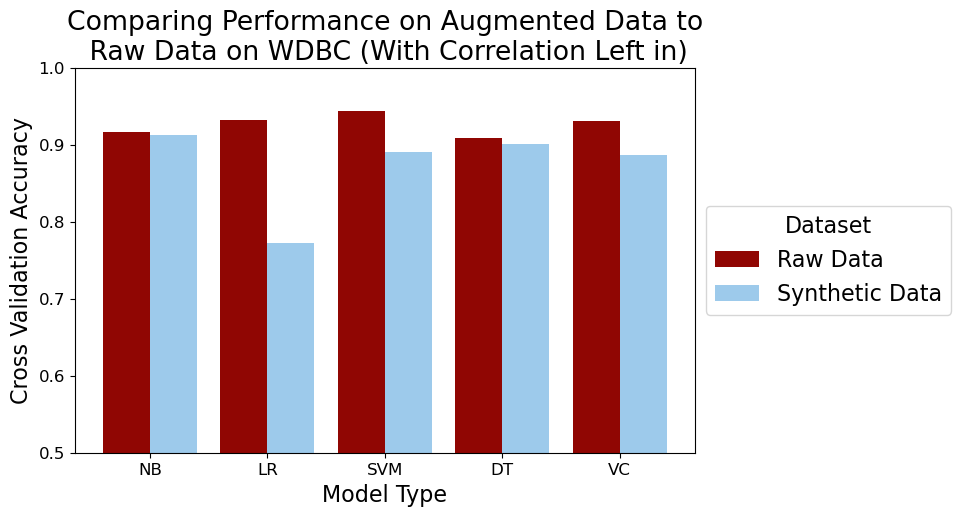

KNN Difference: -4.671807891302482
NB Difference: -0.3089495739716952
LR Difference: -15.950716991653502
SVM Difference: -5.309333292600405
Dt Difference: -0.7795805925854049
VC Difference: -4.351767398214679


In [45]:

wdbc_aug = [np.mean(augNbWDBC), np.mean(augLrWDBC),
        np.mean(augSvmWDBC), np.mean(augDtWDBC), np.mean(augVcWDBC)]
wdbc_reg = [np.mean(nbWDBC), np.mean(lrWDBC),
        np.mean(svmWDBC), np.mean(dtWDBC), np.mean(vcWDBC)]

  
X_axis = np.arange(len(X_vals))
  
plt.bar(X_axis - 0.2, wdbc_reg, 0.4, label = 'Raw Data', color='#900603')
plt.bar(X_axis + 0.2, wdbc_aug, 0.4, label = 'Synthetic Data', color='#9DCAEB')
  
plt.xticks(X_axis, X_vals)
plt.xlabel("Model Type")
plt.ylabel("Cross Validation Accuracy")
plt.ylim(0.5,1)
plt.title("Comparing Performance on Augmented Data to\n Raw Data on WDBC (With Correlation Left in)")
plt.legend(title='Dataset',loc='center left', bbox_to_anchor=(1, 0.5))
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams.update({'font.size': 16})
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)
plt.show()



print('KNN Difference: {}'.format(100 * (np.mean(augKnnWDBC) - np.mean(knnWDBC))))
print('NB Difference: {}'.format(100 * (np.mean(augNbWDBC) - np.mean(nbWDBC))))
print('LR Difference: {}'.format(100 * (np.mean(augLrWDBC) - np.mean(lrWDBC))))
print('SVM Difference: {}'.format(100 * (np.mean(augSvmWDBC) - np.mean(svmWDBC))))
print('Dt Difference: {}'.format(100 * (np.mean(augDtWDBC) - np.mean(dtWDBC))))
print('VC Difference: {}'.format(100 * (np.mean(augVcWDBC) - np.mean(vcWDBC))))

In [116]:
cols = ['ID', 'Diagnosis', 'radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension',
        'radius_SE', 'texture_SE', 'perimeter_SE', 'area_SE', 'smoothness_SE', 'compactness_SE', 'concavity_SE', 'concave_points_SE', 'symmetry_SE', 'fractal_dimension_SE',
        'radius_MAX', 'texture_MAX', 'perimeter_MAX', 'area_MAX', 'smoothness_MAX', 'compactness_MAX', 'concavity_MAX', 'concave_points_MAX', 'symmetry_MAX', 'fractal_dimension_MAX']
df = pd.read_csv('../../../Wisconsin_Database/wdbc.data', header=None)
print(df.shape)
df.columns = cols
df['Diagnosis'] = df['Diagnosis'].map(
                   {'M':True,'B':False})
#Columns Identified by Correlation Matrix
#When Columns were correlated, that which was most correlated with the target variable (Diagnosis)
#Was Kept
colsInUse = ['ID', 'Diagnosis', 'texture', 'smoothness', 'symmetry', 'fractal_dimension', 
                'radius_SE', 'texture_SE', 'smoothness_SE', 'compactness_SE', 'concavity_SE', 'concave_points_SE', 'symmetry_SE', 'fractal_dimension_SE',
                'texture_MAX', 'perimeter_MAX', 'smoothness_MAX', 'compactness_MAX', 'concavity_MAX', 'concave_points_MAX', 'symmetry_MAX', 'fractal_dimension_MAX']

df = df[colsInUse]

print(df.shape)

(569, 32)
(569, 22)


In [47]:
augKnnWDBC_Stripped = []
augNbWDBC_Stripped = []
augLrWDBC_Stripped = []
augSvmWDBC_Stripped = []
augDtWDBC_Stripped = []
augVcWDBC_Stripped = []
print('Data Shape: {}'.format(df.shape))
for i in range(10):
    X = df[colsInUse[2:]]
    y = df[colsInUse[1]]

    SEED = 42 + i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
    finalDataset = generateSyntheticDataset(X_train, y_train, identical = True)
    X_train = finalDataset[finalDataset.columns[:-1]]
    y_train = finalDataset[finalDataset.columns[-1]]
    scaler = StandardScaler()
    scaler.fit(X_train)

    col_names=df.columns[2:]
    scaled_df = pd.DataFrame(X_train, columns=col_names)
    scaled_df.describe().T
    scores = trainModels(X_train, X_test, y_train, y_test)
    augKnnWDBC_Stripped.append(scores[0])
    augNbWDBC_Stripped.append(scores[1])
    augLrWDBC_Stripped.append(scores[2])
    augSvmWDBC_Stripped.append(scores[3])
    augDtWDBC_Stripped.append(scores[4])
    augVcWDBC_Stripped.append(scores[5])
    print('Iteration: {}'.format(i))


print('KNN - Min: {}, Max: {}, Avg: {}'.format(min(augKnnWDBC_Stripped), max(augKnnWDBC_Stripped), sum(augKnnWDBC_Stripped)/len(augKnnWDBC_Stripped)))
#print('   Best Seed: {}'.format(42 + knnScores.index(max(knnScores))))
print('NB  - Min: {}, Max: {}, Avg: {}'.format(min(augNbWDBC_Stripped), max(augNbWDBC_Stripped), sum(augNbWDBC_Stripped)/len(augNbWDBC_Stripped)))
#print('   Best Seed: {}'.format(42 + naiveBaysScores.index(max(naiveBaysScores))))
print('LR  - Min: {}, Max: {}, Avg: {}'.format(min(augLrWDBC_Stripped), max(augLrWDBC_Stripped), sum(augLrWDBC_Stripped)/len(augLrWDBC_Stripped)))
#print('   Best Seed: {}'.format(42 + logisticRegressionScores.index(max(logisticRegressionScores))))
print('SVM - Min: {}, Max: {}, Avg: {}'.format(min(augSvmWDBC_Stripped), max(augSvmWDBC_Stripped), sum(augSvmWDBC_Stripped)/len(augSvmWDBC_Stripped)))
#print('   Best Seed: {}'.format(42 + svmRegressionScores.index(max(svmRegressionScores))))
print('DT  - Min: {}, Max: {}, Avg: {}'.format(min(augDtWDBC_Stripped), max(augDtWDBC_Stripped), sum(augDtWDBC_Stripped)/len(augDtWDBC_Stripped)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))
print('VC  - Min: {}, Max: {}, Avg: {}'.format(min(augVcWDBC_Stripped), max(augVcWDBC_Stripped), sum(augVcWDBC_Stripped)/len(augVcWDBC_Stripped)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))


Data Shape: (569, 22)
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
KNN - Min: 0.9135802469135802, Max: 0.951219512195122, Avg: 0.9344228612163181
NB  - Min: 0.8631578947368421, Max: 0.9534883720930233, Avg: 0.900846592871952
LR  - Min: 0.9135802469135802, Max: 0.9523809523809524, Avg: 0.9368978255229836
SVM - Min: 0.9135802469135802, Max: 0.9736842105263158, Avg: 0.9386946135668677
DT  - Min: 0.8333333333333333, Max: 0.9487179487179487, Avg: 0.8889220470003114
VC  - Min: 0.9047619047619047, Max: 0.963855421686747, Avg: 0.934891279643735


In [48]:
knnWDBC_Stripped = []
nbWDBC_Stripped = []
lrWDBC_Stripped = []
svmWDBC_Stripped = []
dtWDBC_Stripped = []
vcWDBC_Stripped = []
for i in range(10):
    X = df[colsInUse[2:]]
    y = df[colsInUse[1]]

    SEED = 42 + i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
    scaler = StandardScaler()
    scaler.fit(X_train)

    col_names=df.columns[2:]
    scaled_df = pd.DataFrame(X_train, columns=col_names)
    scaled_df.describe().T
    scores = trainModels(X_train, X_test, y_train, y_test)
    knnWDBC_Stripped.append(scores[0])
    nbWDBC_Stripped.append(scores[1])
    lrWDBC_Stripped.append(scores[2])
    svmWDBC_Stripped.append(scores[3])
    dtWDBC_Stripped.append(scores[4])
    vcWDBC_Stripped.append(scores[5])
    print('Iteration: {}'.format(i))



print('KNN - Min: {}, Max: {}, Avg: {}'.format(min(knnWDBC_Stripped), max(knnWDBC_Stripped), sum(knnWDBC_Stripped)/len(knnWDBC_Stripped)))
#print('   Best Seed: {}'.format(42 + knnScores.index(max(knnScores))))
print('NB  - Min: {}, Max: {}, Avg: {}'.format(min(nbWDBC_Stripped), max(nbWDBC_Stripped), sum(nbWDBC_Stripped)/len(nbWDBC_Stripped)))
#print('   Best Seed: {}'.format(42 + naiveBaysScores.index(max(naiveBaysScores))))
print('LR  - Min: {}, Max: {}, Avg: {}'.format(min(lrWDBC_Stripped), max(lrWDBC_Stripped), sum(lrWDBC_Stripped)/len(lrWDBC_Stripped)))
#print('   Best Seed: {}'.format(42 + logisticRegressionScores.index(max(logisticRegressionScores))))
print('SVM - Min: {}, Max: {}, Avg: {}'.format(min(svmWDBC_Stripped), max(svmWDBC_Stripped), sum(svmWDBC_Stripped)/len(svmWDBC_Stripped)))
#print('   Best Seed: {}'.format(42 + svmRegressionScores.index(max(svmRegressionScores))))
print('DT  - Min: {}, Max: {}, Avg: {}'.format(min(dtWDBC_Stripped), max(dtWDBC_Stripped), sum(dtWDBC_Stripped)/len(dtWDBC_Stripped)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))
print('VC  - Min: {}, Max: {}, Avg: {}'.format(min(vcWDBC_Stripped), max(vcWDBC_Stripped), sum(vcWDBC_Stripped)/len(vcWDBC_Stripped)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
KNN - Min: 0.8947368421052632, Max: 0.9500000000000001, Avg: 0.9283495196580919
NB  - Min: 0.8723404255319149, Max: 0.9411764705882352, Avg: 0.9016699949991132
LR  - Min: 0.9010989010989012, Max: 0.9620253164556962, Avg: 0.9339956741870404
SVM - Min: 0.9010989010989012, Max: 0.9743589743589743, Avg: 0.9430333325054374
DT  - Min: 0.8059701492537312, Max: 0.9382716049382716, Avg: 0.8933550070211964
VC  - Min: 0.896551724137931, Max: 0.9655172413793104, Avg: 0.9313920613391063


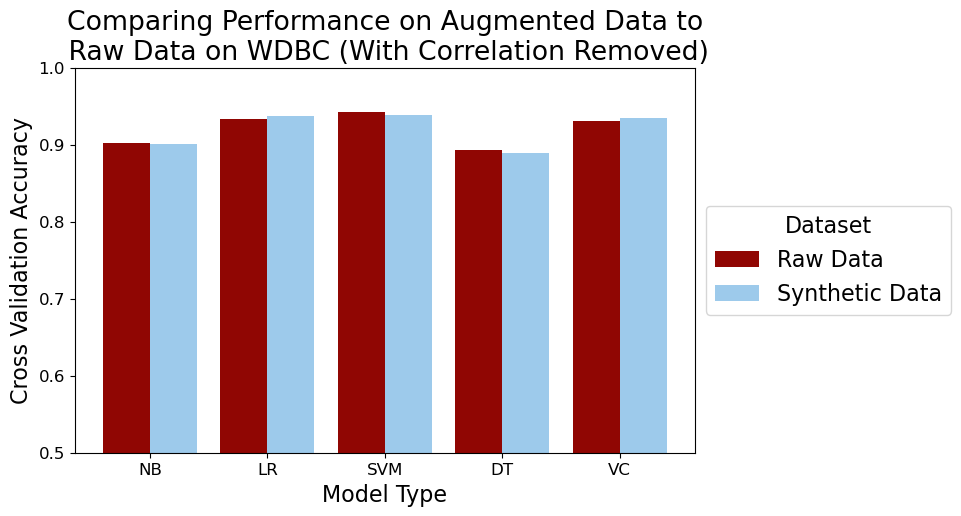

KNN Difference: 0.6073341558226253
NB Difference: -0.08234021271611436
LR Difference: 0.29021513359431816
SVM Difference: -0.4338718938569852
Dt Difference: -0.44329600208848907
VC Difference: 0.3499218304628626


In [50]:
wdbc_stripped_aug = [np.mean(augNbWDBC_Stripped), np.mean(augLrWDBC_Stripped),
        np.mean(augSvmWDBC_Stripped), np.mean(augDtWDBC_Stripped), np.mean(augVcWDBC_Stripped)]
wdbc_stripped_reg = [np.mean(nbWDBC_Stripped), np.mean(lrWDBC_Stripped),
        np.mean(svmWDBC_Stripped), np.mean(dtWDBC_Stripped), np.mean(vcWDBC_Stripped)]

X_axis = np.arange(len(X_vals))
  
plt.bar(X_axis - 0.2, wdbc_stripped_reg, 0.4, label = 'Raw Data', color='#900603')
plt.bar(X_axis + 0.2, wdbc_stripped_aug, 0.4, label = 'Synthetic Data', color='#9DCAEB')
  
plt.xticks(X_axis, X_vals)
plt.xlabel("Model Type")
plt.ylabel("Cross Validation Accuracy")
plt.ylim(0.5,1)
plt.title("Comparing Performance on Augmented Data to\n Raw Data on WDBC (With Correlation Removed)")
plt.legend(title='Dataset',loc='center left', bbox_to_anchor=(1, 0.5))
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams.update({'font.size': 16})
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)
plt.show()

print('KNN Difference: {}'.format(100 * (np.mean(augKnnWDBC_Stripped) - np.mean(knnWDBC_Stripped))))
print('NB Difference: {}'.format(100 * (np.mean(augNbWDBC_Stripped) - np.mean(nbWDBC_Stripped))))
print('LR Difference: {}'.format(100 * (np.mean(augLrWDBC_Stripped) - np.mean(lrWDBC_Stripped))))
print('SVM Difference: {}'.format(100 * (np.mean(augSvmWDBC_Stripped) - np.mean(svmWDBC_Stripped))))
print('Dt Difference: {}'.format(100 * (np.mean(augDtWDBC_Stripped) - np.mean(dtWDBC_Stripped))))
print('VC Difference: {}'.format(100 * (np.mean(augVcWDBC_Stripped) - np.mean(vcWDBC_Stripped))))

[0.952020635412493, 0.9565990029214463, 0.959822185952666, 0.9203962370083898, 0.958557008930662]
[0.951396954915382, 0.9578669637321054, 0.9527697318427277, 0.6084656118315352, 0.9556929737659697]
[0.9161168304024004, 0.9321837708730898, 0.9439340298677965, 0.9089544961868775, 0.9304950462802857]
[0.9130273346626835, 0.7726766009565548, 0.8908406969417925, 0.9011586902610235, 0.8869773722981389]
[0.9016699949991132, 0.9339956741870404, 0.9430333325054375, 0.8933550070211963, 0.9313920613391063]
[0.900846592871952, 0.9368978255229836, 0.9386946135668677, 0.8889220470003114, 0.934891279643735]


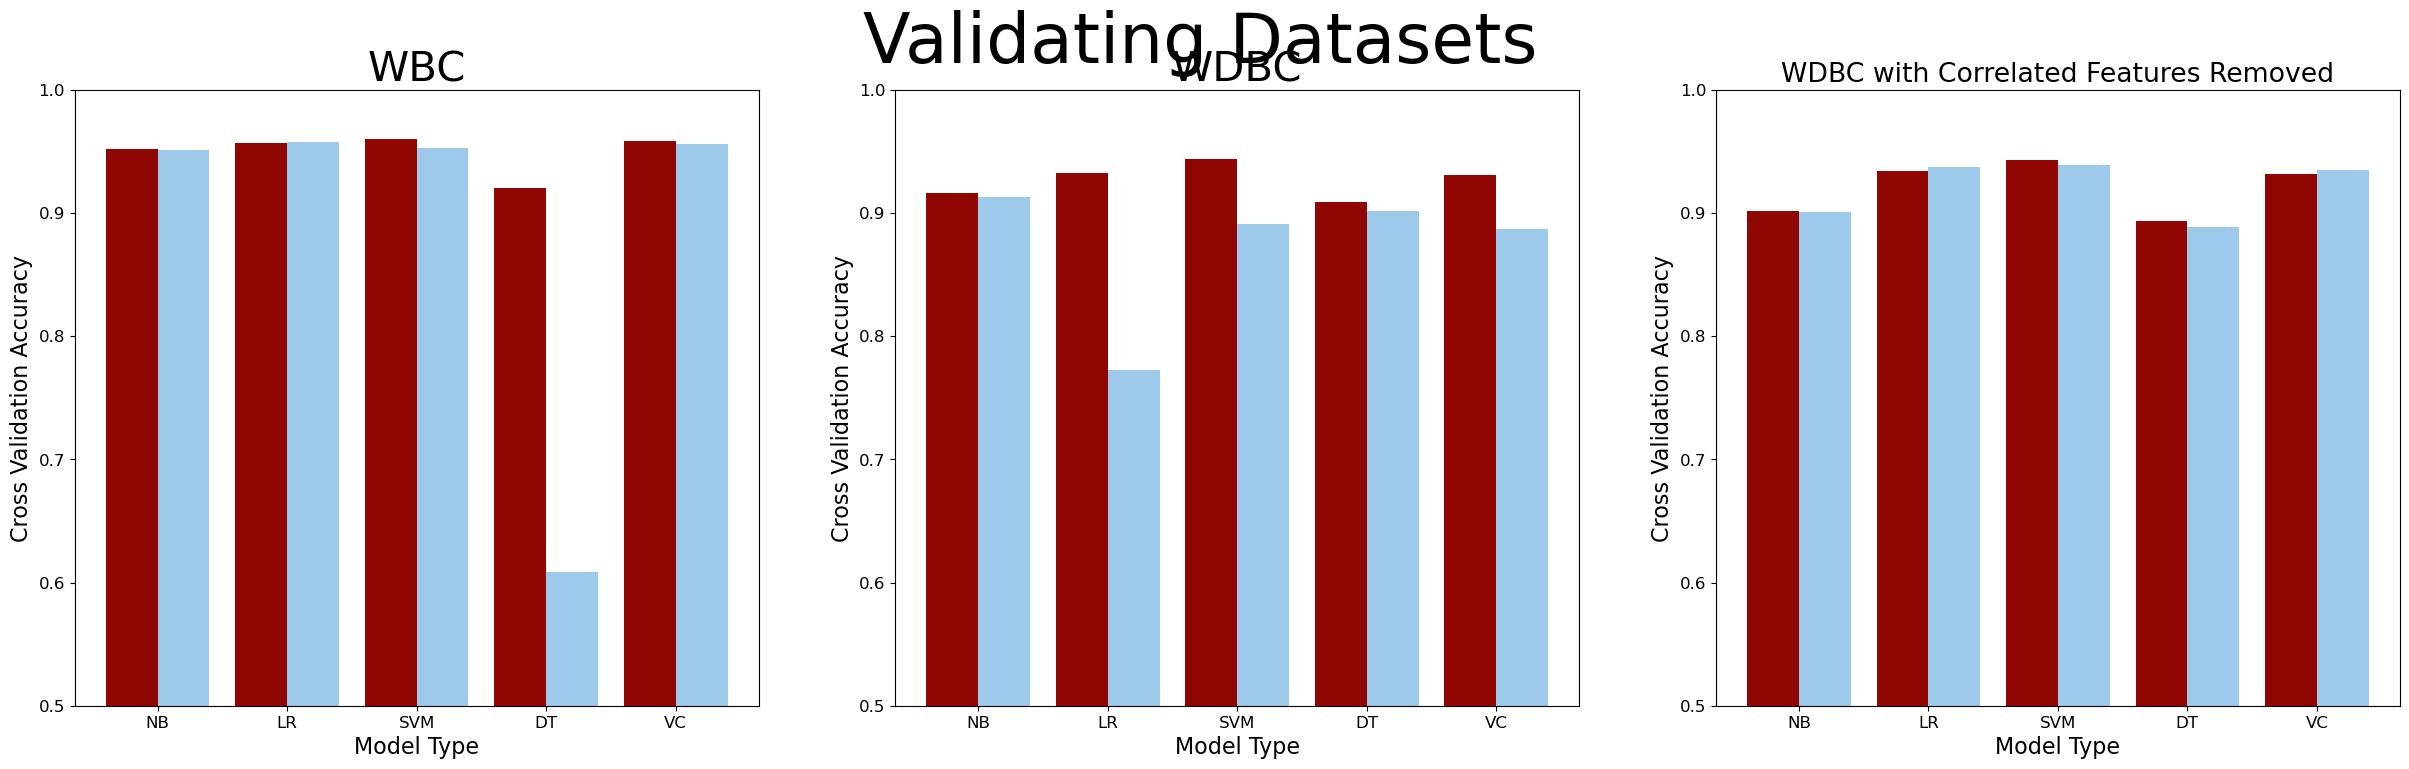

In [93]:
print(wbc_reg)
print(wbc_aug)

print(wdbc_reg)
print(wdbc_aug)

print(wdbc_stripped_reg)
print(wdbc_stripped_aug)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))
fig.suptitle('Validating Datasets', size=50)

ax1.bar(X_axis - 0.2, wbc_reg, 0.4, label = 'Raw Data', color='#900603')
ax1.bar(X_axis + 0.2, wbc_aug, 0.4, label = 'Synthetic Data', color='#9DCAEB')
ax1.set_xticks(X_axis, X_vals)
ax1.set_xlabel("Model Type")
ax1.set_ylabel("Cross Validation Accuracy")
ax1.set_ylim(0.5,1)
ax1.set_title("WBC", size=30)


ax2.bar(X_axis - 0.2, wdbc_reg, 0.4, label = 'Raw Data', color='#900603')
ax2.bar(X_axis + 0.2, wdbc_aug, 0.4, label = 'Synthetic Data', color='#9DCAEB')
ax2.set_xticks(X_axis, X_vals)
ax2.set_xlabel("Model Type")
ax2.set_ylabel("Cross Validation Accuracy")
ax2.set_ylim(0.5,1)
ax2.set_title("WDBC", size=30)


ax3.bar(X_axis - 0.2, wdbc_stripped_reg, 0.4, label = 'Raw Data', color='#900603')
ax3.bar(X_axis + 0.2, wdbc_stripped_aug, 0.4, label = 'Synthetic Data', color='#9DCAEB')
ax3.set_xticks(X_axis, X_vals)
ax3.set_xlabel("Model Type")
ax3.set_ylabel("Cross Validation Accuracy")
ax3.set_ylim(0.5,1)
ax3.set_title("WDBC with Correlated Features Removed")




plt.show()


[0.952020635412493, 0.9565990029214463, 0.959822185952666, 0.9203962370083898, 0.958557008930662]
[0.951396954915382, 0.9578669637321054, 0.9527697318427277, 0.6084656118315352, 0.9556929737659697]
[0.9161168304024004, 0.9321837708730898, 0.9439340298677965, 0.9089544961868775, 0.9304950462802857]
[0.9130273346626835, 0.7726766009565548, 0.8908406969417925, 0.9011586902610235, 0.8869773722981389]
[0.9016699949991132, 0.9339956741870404, 0.9430333325054375, 0.8933550070211963, 0.9313920613391063]
[0.900846592871952, 0.9368978255229836, 0.9386946135668677, 0.8889220470003114, 0.934891279643735]


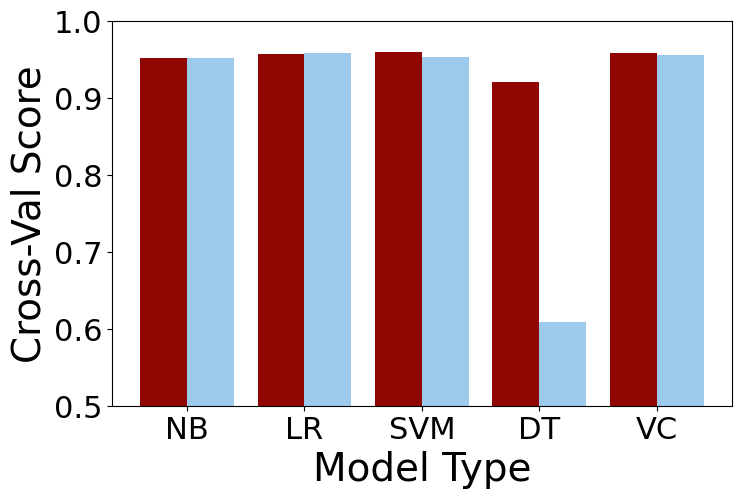

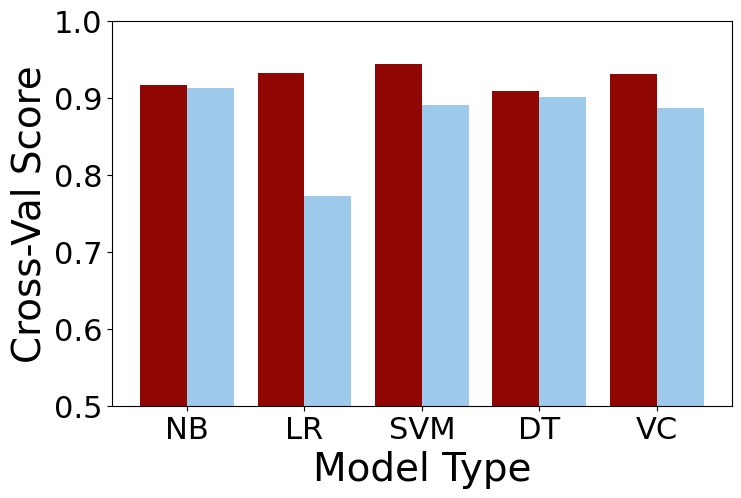

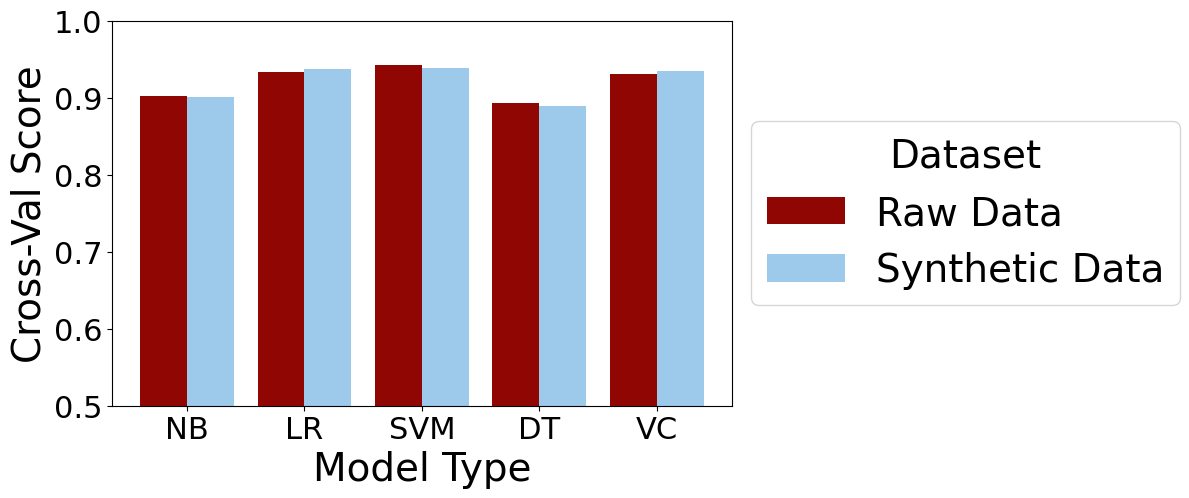

In [113]:
print(wbc_reg)
print(wbc_aug)

print(wdbc_reg)
print(wdbc_aug)

print(wdbc_stripped_reg)
print(wdbc_stripped_aug)


plt.bar(X_axis - 0.2, wbc_reg, 0.4, label = 'Raw Data', color='#900603')
plt.bar(X_axis + 0.2, wbc_aug, 0.4, label = 'Synthetic Data', color='#9DCAEB')
plt.xticks(X_axis, X_vals)
plt.xlabel("Model Type")
plt.ylabel("Cross-Val Score")
plt.ylim(0.5,1)
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams.update({'font.size': 28})
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
plt.show()


plt.bar(X_axis - 0.2, wdbc_reg, 0.4, label = 'Raw Data', color='#900603')
plt.bar(X_axis + 0.2, wdbc_aug, 0.4, label = 'Synthetic Data', color='#9DCAEB')
plt.xticks(X_axis, X_vals)
plt.xlabel("Model Type")
plt.ylabel("Cross-Val Score")
plt.ylim(0.5,1)
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams.update({'font.size': 28})
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
plt.show()

plt.bar(X_axis - 0.2, wdbc_stripped_reg, 0.4, label = 'Raw Data', color='#900603')
plt.bar(X_axis + 0.2, wdbc_stripped_aug, 0.4, label = 'Synthetic Data', color='#9DCAEB')
plt.xticks(X_axis, X_vals)
plt.xlabel("Model Type")
plt.ylabel("Cross-Val Score")
plt.ylim(0.5,1)
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams.update({'font.size': 28})
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
plt.legend(title='Dataset',loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()




plt.show()


In [ ]:

cervical_df = pd.read_csv('risk_factors_cervical_cancer.csv')

cervicalCols = ['Age', 'Number of sexual partners', 'First sexual intercourse',
                'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
                'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
                'IUD (years)', 'STDs (number)', 'STDs:condylomatosis',
                'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis',
                'STDs:syphilis', 'STDs:pelvic inflammatory disease',
                'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:HIV',
                'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
                'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
                'Dx:Cancer', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology',
                'Biopsy']

cervical_df = pd.read_csv('risk_factors_cervical_cancer.csv')
cervical_df = cervical_df[cervicalCols]
cervicalAllNullsRemoved = removeEntriesWithNulls(cervical_df)
print(cervicalAllNullsRemoved.shape)


(59, 32)


In [ ]:
knnCER = []
nbCER = []
lrCER = []
svmCER = []
dtCER = []
vcCER = []
for i in range(10):
    X = cervicalAllNullsRemoved[cervicalCols[:-4]]
    y = cervicalAllNullsRemoved[cervicalCols[-1]]

    SEED = 42 + i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
    #print('Augmented X Train: {}'.format(X_train.shape))
    #print('Augmented y_train: {}'.format(y_train.shape))
    scaler = StandardScaler()
    scaler.fit(X_train)

    col_names=df.columns[2:]
    scaled_df = pd.DataFrame(X_train, columns=col_names)
    scaled_df.describe().T
    scores = trainModels(X_train, X_test, y_train, y_test)
    knnCER.append(scores[0])
    nbCER.append(scores[1])
    lrCER.append(scores[2])
    svmCER.append(scores[3])
    dtCER.append(scores[4])
    vcCER.append(scores[5])
    print('Iteration: {}'.format(i))


print('KNN - Min: {}, Max: {}, Avg: {}'.format(min(knnCER), max(knnCER), sum(knnCER)/len(knnCER)))
#print('   Best Seed: {}'.format(42 + knnScores.index(max(knnScores))))
print('NB  - Min: {}, Max: {}, Avg: {}'.format(min(nbCER), max(nbCER), sum(nbCER)/len(nbCER)))
#print('   Best Seed: {}'.format(42 + naiveBaysScores.index(max(naiveBaysScores))))
print('LR  - Min: {}, Max: {}, Avg: {}'.format(min(lrCER), max(lrCER), sum(lrCER)/len(lrCER)))
#print('   Best Seed: {}'.format(42 + logisticRegressionScores.index(max(logisticRegressionScores))))
print('SVM - Min: {}, Max: {}, Avg: {}'.format(min(svmCER), max(svmCER), sum(svmCER)/len(svmCER)))
#print('   Best Seed: {}'.format(42 + svmRegressionScores.index(max(svmRegressionScores))))
print('DT  - Min: {}, Max: {}, Avg: {}'.format(min(dtCER), max(dtCER), sum(dtCER)/len(dtCER)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))
print('VC  - Min: {}, Max: {}, Avg: {}'.format(min(vcCER), max(vcCER), sum(vcCER)/len(vcCER)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
KNN - Min: 0.0, Max: 1.0, Avg: 0.32999999999999996
NB  - Min: 0.0, Max: 0.6, Avg: 0.33817460317460324
LR  - Min: 0.0, Max: 0.5, Avg: 0.1
SVM - Min: 0.0, Max: 0.5, Avg: 0.1
DT  - Min: 0.0, Max: 0.5, Avg: 0.1
VC  - Min: 0.0, Max: 0.5, Avg: 0.1


In [ ]:

cervical_df = pd.read_csv('risk_factors_cervical_cancer.csv')
cervical_df = cervical_df[cervicalCols]
cervicalAllNullsSyntheticFilled = genSyntheticFillNulls(cervical_df)
print(cervicalAllNullsSyntheticFilled.shape)

for i in cervicalAllNullsSyntheticFilled:
        cervicalAllNullsSyntheticFilled[i] = cervicalAllNullsSyntheticFilled[i].astype(np.float)

(858, 32)


In [ ]:
augKnnCER = []
augNbCER = []
augLrCER = []
augSvmCER = []
augDtCER = []
augVcCER = []
for i in range(10):
    X = cervicalAllNullsSyntheticFilled[cervicalCols[:-4]]
    y = cervicalAllNullsSyntheticFilled[cervicalCols[-1]]

    SEED = 42 + i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
    #print('Augmented X Train: {}'.format(X_train.shape))
    #print('Augmented y_train: {}'.format(y_train.shape))
    scaler = StandardScaler()
    scaler.fit(X_train)

    col_names=df.columns[2:]
    scaled_df = pd.DataFrame(X_train, columns=col_names)
    scaled_df.describe().T
    scores = trainModels(X_train, X_test, y_train, y_test)
    augKnnCER.append(scores[0])
    augNbCER.append(scores[1])
    augLrCER.append(scores[2])
    augSvmCER.append(scores[3])
    augDtCER.append(scores[4])
    augVcCER.append(scores[5])
    print('Iteration: {}'.format(i))


print('KNN - Min: {}, Max: {}, Avg: {}'.format(min(augKnnCER), max(augKnnCER), sum(augKnnCER)/len(augKnnCER)))
#print('   Best Seed: {}'.format(42 + knnScores.index(max(knnScores))))
print('NB  - Min: {}, Max: {}, Avg: {}'.format(min(augNbCER), max(augNbCER), sum(augNbCER)/len(augNbCER)))
#print('   Best Seed: {}'.format(42 + naiveBaysScores.index(max(naiveBaysScores))))
print('LR  - Min: {}, Max: {}, Avg: {}'.format(min(augLrCER), max(augLrCER), sum(augLrCER)/len(augLrCER)))
#print('   Best Seed: {}'.format(42 + logisticRegressionScores.index(max(logisticRegressionScores))))
print('SVM - Min: {}, Max: {}, Avg: {}'.format(min(augSvmCER), max(augSvmCER), sum(augSvmCER)/len(augSvmCER)))
#print('   Best Seed: {}'.format(42 + svmRegressionScores.index(max(svmRegressionScores))))
print('DT  - Min: {}, Max: {}, Avg: {}'.format(min(augDtCER), max(augDtCER), sum(augDtCER)/len(augDtCER)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))
print('VC  - Min: {}, Max: {}, Avg: {}'.format(min(augVcCER), max(augVcCER), sum(augVcCER)/len(augVcCER)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
KNN - Min: 0.0, Max: 0.0, Avg: 0.0
NB  - Min: 0.05228758169934641, Max: 0.26666666666666666, Avg: 0.1342349010291002
LR  - Min: 0.0, Max: 0.18181818181818182, Avg: 0.01818181818181818
SVM - Min: 0.0, Max: 0.0, Avg: 0.0
DT  - Min: 0.0, Max: 0.2962962962962963, Avg: 0.15648073174388966
VC  - Min: 0.0, Max: 0.0, Avg: 0.0


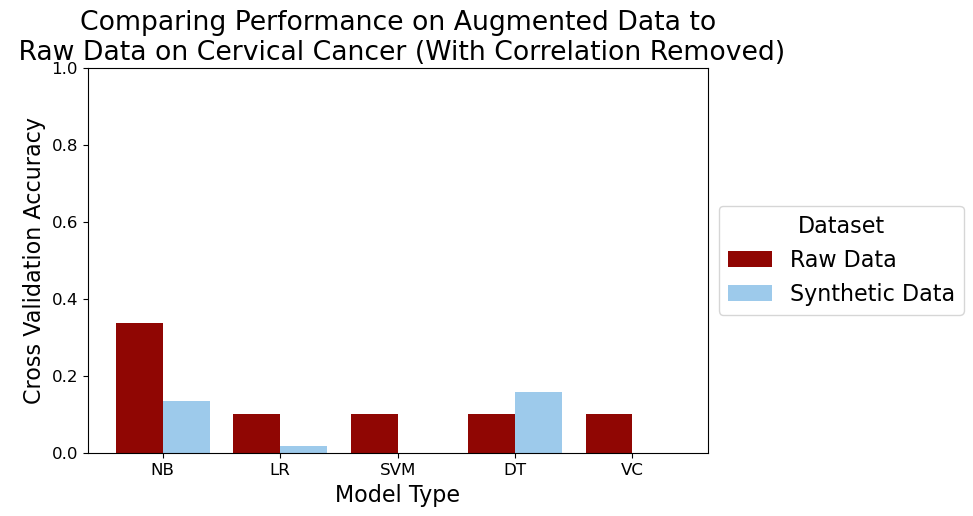

In [53]:
cer_aug = [np.mean(augNbCER), np.mean(augLrCER),
        np.mean(augSvmCER), np.mean(augDtCER), np.mean(augVcCER)]
cer_reg = [np.mean(nbCER), np.mean(lrCER),
        np.mean(svmCER), np.mean(dtCER), np.mean(vcCER)]

X_axis = np.arange(len(X_vals))

plt.bar(X_axis - 0.2, cer_reg, 0.4, label = 'Raw Data', color='#900603')
plt.bar(X_axis + 0.2, cer_aug, 0.4, label = 'Synthetic Data', color='#9DCAEB')
  
plt.xticks(X_axis, X_vals)
plt.xlabel("Model Type")
plt.ylabel("Cross Validation Accuracy")
plt.ylim(0,1)
plt.title("Comparing Performance on Augmented Data to\n Raw Data on Cervical Cancer (With Correlation Removed)")
plt.legend(title='Dataset',loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()